<a href="https://colab.research.google.com/github/akumuyi/FX_DIRECTION_PREDICTIVE_MODEL/blob/main/Summative_Intro_to_ml_%5BAbiodun_Kumuyi%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FINANCIAL MARKETS DAILY DIRECTIONAL BIAS (UP/DOWN) PREDICTIVE MODEL**

### **Data Source:** [DukasCopy](https://www.dukascopy.com/swiss/english/marketwatch/historical/)

In [ ]:
# INSTALL DEPENDENCIES
!pip install scikeras
!pip install scikit-optimize
try:
    import talib
except ImportError:
    try:
        # Attempt to install TA-Lib
        !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
        !tar xvzf ta-lib-0.4.0-src.tar.gz
        %cd ta-lib/
        !./configure --prefix=/usr
        !make
        !make install
        !pip install TA-Lib
        %cd ..
        import talib
    except:
        # Fallback to pure Python implementation
        !pip install ta
        import ta
        USE_TA_LIB = False
    else:
        USE_TA_LIB = True


# Case Study and Implementation




In [3]:
# Import Necessary Libraries
# Data handling
import numpy as np
import pandas as pd
import ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Preprocessing & model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Classical ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Neural network
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Saving models
import joblib
import os
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Manually Compute Technical Indicators to enrich dataset**

### All these indicators were calculated and added as features:

| Indicator                  | Purpose                   | Calculation Method                     |
|---------------------------|---------------------------|----------------------------------------|
| RSI                       | Momentum measurement      | TA-Lib or manual calculation           |
| MACD                      | Trend-following momentum  | TA-Lib or EMA difference               |
| ATR                       | Volatility measurement    | TA-Lib or true range averaging         |
| ADX                       | Trend strength            | TA-Lib or directional movement         |
| Moving Averages (5,10,20) | Smooth price trends       | Rolling mean                           |


- All features were scaled and fed into both classical ML and NN models.The added features will help the model perform better compared to using only raw prices, as they capture:

- Momentum (RSI)

- Trends (MACD)

- Volatility (ATR)

- Market activity (Volume_log)

In [4]:
# TECHNICAL INDICATOR CALCULATIONS

def calculate_technical_indicators(df):
    """Calculate technical indicators with fallback options"""
    # Moving averages
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()

    # RSI
    try:
        if USE_TA_LIB:
            df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
        else:
            from ta.momentum import RSIIndicator
            df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    except:
        # Manual RSI calculation
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    try:
        if USE_TA_LIB:
            macd, _, _ = talib.MACD(df['Close'])
            df['MACD'] = macd
        else:
            from ta.trend import MACD
            df['MACD'] = MACD(df['Close']).macd()
    except:
        # Manual MACD
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26

    # ATR
    try:
        if USE_TA_LIB:
            df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
        else:
            from ta.volatility import AverageTrueRange
            df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    except:
        # Manual ATR
        tr = np.maximum.reduce([
            df['High'] - df['Low'],
            (df['High'] - df['Close'].shift()).abs(),
            (df['Low'] - df['Close'].shift()).abs()
        ])
        df['ATR'] = tr.rolling(14).mean()

    # ADX
    try:
        if USE_TA_LIB:
            df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
        else:
            from ta.trend import ADXIndicator
            df['ADX'] = ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()
    except:
        # Skip ADX if not available
        df['ADX'] = 0

    return df

## **Function Definitions**

### Define needed functions here so they can be reusable to adhere to the DRY code requirement, also perform some feature engineering like creating additional features.

In [5]:
# LOAD FUNCTION
def load_and_preprocess_data(url):
    df = pd.read_csv(
        url,
        parse_dates=True,
        index_col=0
    )

    # Convert index to datetime
    df.index = pd.to_datetime(df.index, format="%d.%m.%Y %H:%M:%S.%f")

    # Create target: 1 if next day's Close > today's Close, else 0
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df = df.dropna(subset=["Target"])

    # Use indicator function
    df = calculate_technical_indicators(df)

    # Add returns and volatility
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(5).std()

    # Log-transform volume
    df["Volume_log"] = np.log1p(df["Volume"])
    df = df.drop(columns=['Volume'])

    # Additional useful features
    df['Price_Change'] = df['Close'] - df['Open']
    df['High_Low_Spread'] = df['High'] - df['Low']

    # Drop any remaining NaNs
    return df.dropna()

def create_train_test_split(df, test_size=0.15, val_size=0.15):
    """Create stratified train/validation/test splits"""
    X = df.drop(columns=['Target'])
    y = df['Target']

    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Second split: train vs val
    val_frac = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
    )

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_features(X_train, X_val, X_test):
    """Scale features with standardization"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

def evaluate_model(model, X, y, model_type='sklearn'):
    """Evaluate model and return comprehensive metrics"""
    if model_type == 'keras':
        y_pred = (model.predict(X) > 0.5).astype(int).flatten()
        loss = model.evaluate(X, y, verbose=0)[0]
    else:
        y_pred = model.predict(X)
        loss = 'N/A'

    return {
        'accuracy': accuracy_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_pred),
        'loss': loss
    }

def create_nn_model(input_dim, optimizer='adam', learning_rate=0.001,
                   regularizer=None, reg_strength=0.01,
                   layers=[64, 32], dropout_rate=0.0,
                   activation='relu'):
    """Create modular neural network model"""
    model = Sequential()

    # Regularization selection
    if regularizer == 'l1':
        reg = l1(reg_strength)
    elif regularizer == 'l2':
        reg = l2(reg_strength)
    elif regularizer == 'l1_l2':
        reg = l1_l2(reg_strength)
    else:
        reg = None

    # Build layers
    for i, units in enumerate(layers):
        if i == 0:
            model.add(Dense(units, input_dim=input_dim,
                          kernel_regularizer=reg))
        else:
            model.add(Dense(units, kernel_regularizer=reg))

        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation(activation))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    elif optimizer == 'adamw':
        opt = AdamW(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                 loss='binary_crossentropy',
                 metrics=['accuracy', Precision(), Recall()])
    return model

def train_nn_model(model, X_train, y_train, X_val, y_val,
                  epochs=100, batch_size=32, early_stopping=False, patience=5):
    """Train neural network model with optional early stopping"""
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss',
                                      patience=patience,
                                      restore_best_weights=True))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

def summarize_nn(name, model, history, X_eval, y_eval):
    """Enhanced model summary with detailed metrics"""
    # Evaluate
    results = evaluate_model(model, X_eval, y_eval, model_type='keras')

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {results['accuracy']:.4f}, F1: {results['f1']:.4f}")
    print(f"Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}, Loss: {results['loss']:.4f}")

    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title(f"{name} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="val accuracy")
    plt.title(f"{name} Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    y_pred = (model.predict(X_eval) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Down', 'Up'],
               yticklabels=['Down', 'Up'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return results

def optimize_ml_model(model, param_grid, X_train, y_train, scoring='f1'):
    """Optimize ML model with grid search"""
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}")
    print(f"Best {scoring}: {grid.best_score_:.4f}")
    return grid.best_estimator_

# The Dataset
> ***Brief Description:***


**Problem Statement**:  
This project addresses the challenge of predicting daily directional movements (Up/Down) in the EUR/USD currency pair, a critical task for forex traders and algorithmic trading systems. By forecasting price trends, we aim to provide actionable insights for risk management and trading strategy optimization.  

**Dataset**:  
We utilize **20 years of daily EUR/USD historical data** (2003-2023) containing:  
1. **Core Price Metrics**:  
   - Open, High, Low, Close prices  
   - Trading Volume  
2. **Engineered Technical Indicators**:  
   - Momentum: RSI (Relative Strength Index)  
   - Trend: MACD (Moving Average Convergence Divergence), ADX (Average Directional Index)  
   - Volatility: ATR (Average True Range)  
   - Moving Averages: 5-day, 10-day, 20-day  
3. **Derived Features**:  
   - Daily Returns (`(Close_t - Close_{t-1})/Close_{t-1}`)  
   - Price Change (`Close - Open`)  
   - Volatility (5-day rolling standard deviation of returns)  
   - Log-Transformed Volume (to normalize skew)  

**Key Characteristics**:  
- 5,300+ daily observations  
- 15 predictive features after engineering  
- Binary target: `1` if next day's close > current close, `0` otherwise  
- Periods covering major market events (e.g., 2008 crisis, COVID-19)  

**Value Proposition**:  
The solution transforms raw market data into a predictive framework, enabling data-driven trading decisions through optimized machine learning models.


## **Data Loading and Preprocessing**

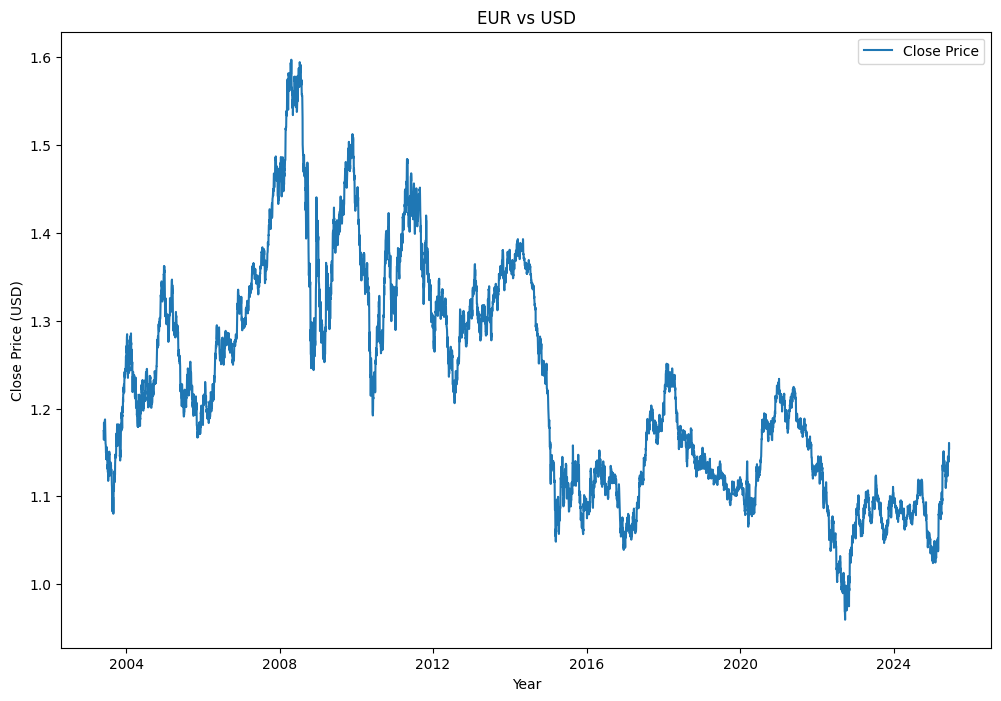

<Figure size 1400x1000 with 0 Axes>

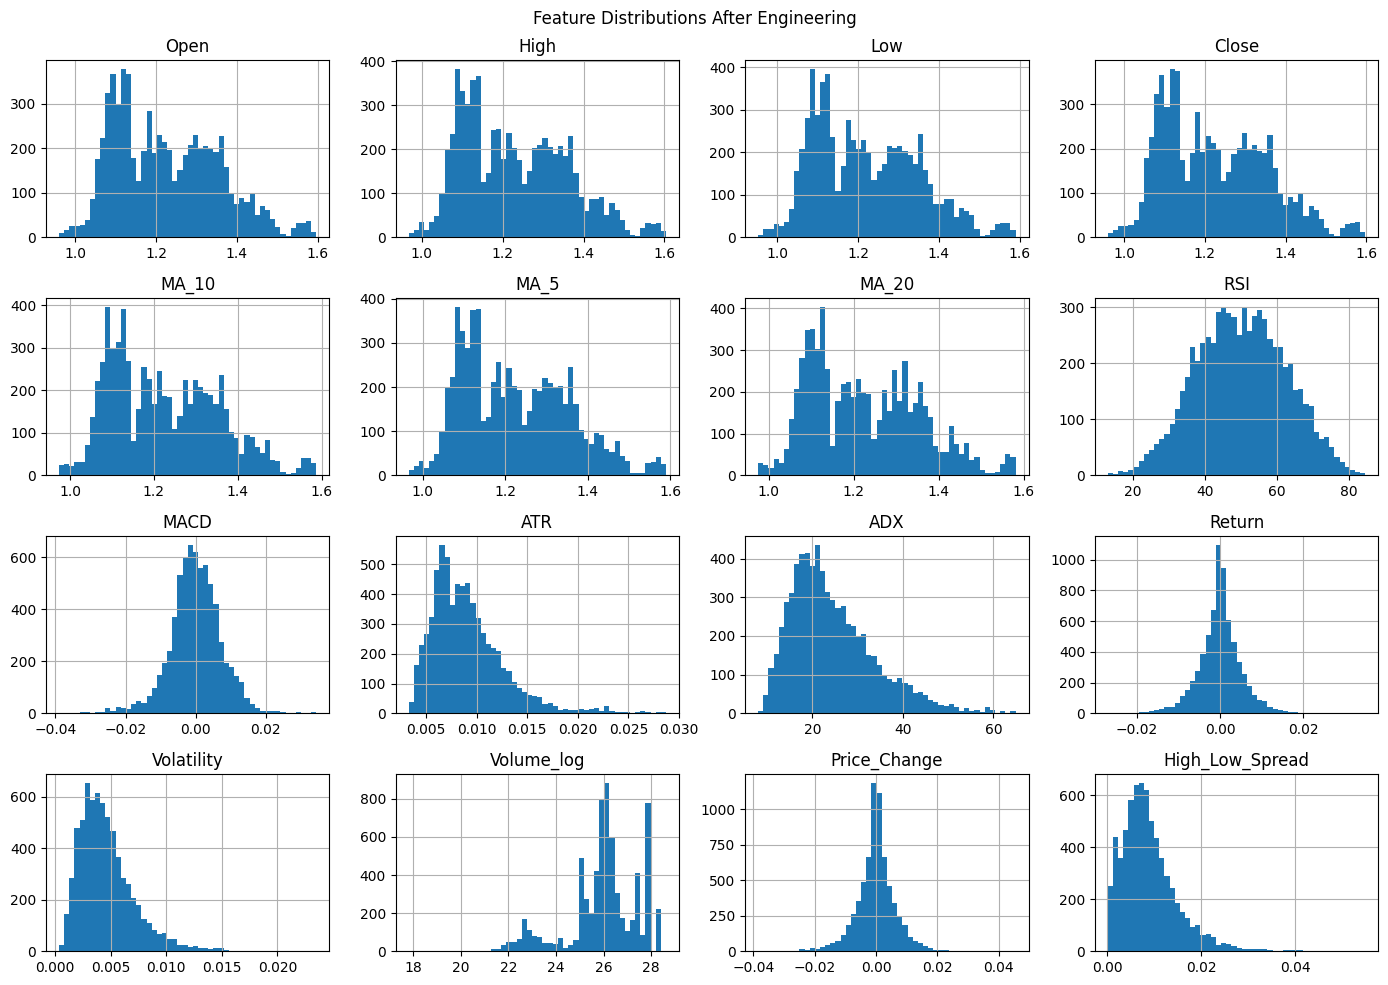

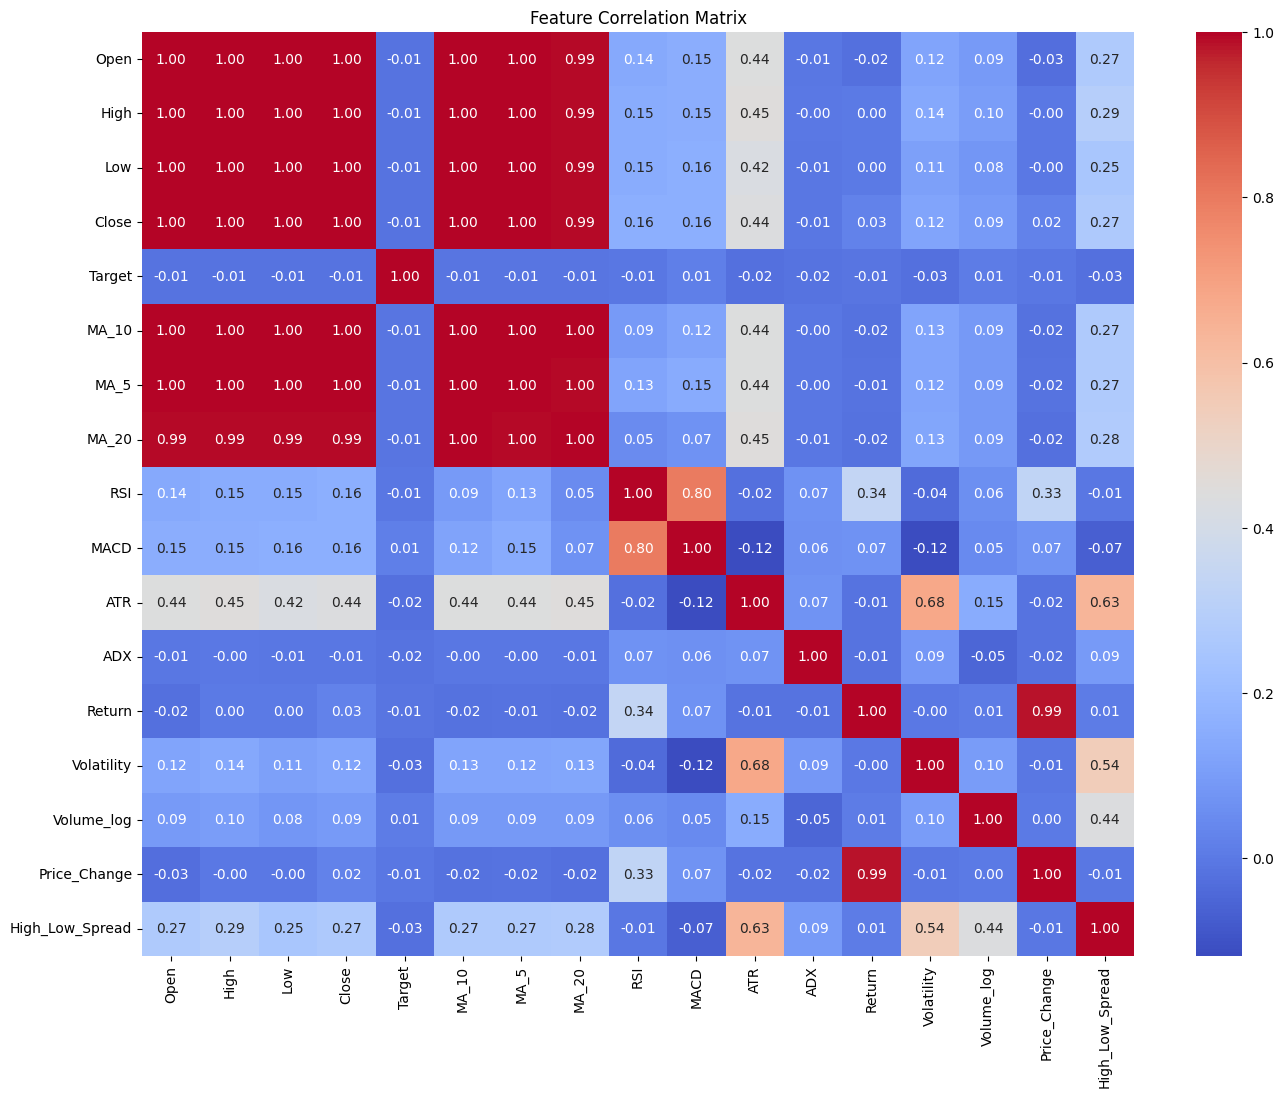

Train: (4811, 16), Val: (1032, 16), Test: (1032, 16)


In [6]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
# Load and preprocess data
DATA_URL = 'https://docs.google.com/spreadsheets/d/1vy592idgw6ifdccWXf1nV6Wf1VGkqcvCoj4OnbU4loI/export?format=csv'
df = load_and_preprocess_data(DATA_URL)

# Plot EURUSD close price over time
plt.figure(figsize=(12,8))
# Use the DataFrame index for the time axis
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('EUR vs USD')
plt.xlabel('Year')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

# Feature engineering
df['Price_Change'] = df['Close'] - df['Open']
df['High_Low_Spread'] = df['High'] - df['Low']
df['MA_5'] = df['Close'].rolling(5).mean()
df['MA_20'] = df['Close'].rolling(20).mean()

# Drop any remaining NaNs
df = df.dropna()

# Visualize feature distributions
plt.figure(figsize=(14, 10))
df.drop(columns=['Target']).hist(bins=50, figsize=(14, 10))
plt.suptitle("Feature Distributions After Engineering")
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# Create splits
X_train, X_val, X_test, y_train, y_val, y_test = create_train_test_split(
    df, test_size=0.15, val_size=0.15
)

# Scale features
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(
    X_train, X_val, X_test
)

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6875 entries, 2003-06-24 to 2025-06-13
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             6875 non-null   float64
 1   High             6875 non-null   float64
 2   Low              6875 non-null   float64
 3   Close            6875 non-null   float64
 4   Target           6875 non-null   int64  
 5   MA_10            6875 non-null   float64
 6   MA_5             6875 non-null   float64
 7   MA_20            6875 non-null   float64
 8   RSI              6875 non-null   float64
 9   MACD             6875 non-null   float64
 10  ATR              6875 non-null   float64
 11  ADX              6875 non-null   float64
 12  Return           6875 non-null   float64
 13  Volatility       6875 non-null   float64
 14  Volume_log       6875 non-null   float64
 15  Price_Change     6875 non-null   float64
 16  High_Low_Spread  6875 non-null   float64
d

,Open,High,Low,Close,Target,MA_10,MA_5,MA_20,RSI,MACD,ATR,ADX,Return,Volatility,Volume_log,Price_Change,High_Low_Spread
count,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000,6875.000000
mean,1.225426,1.229984,1.220967,1.225464,0.502400,1.225475,1.225465,1.225500,50.076809,-0.000036,0.009076,24.530043,0.000014,0.004632,25.986794,0.000038,0.009017
std,0.128568,0.129356,0.127697,0.128552,0.500031,0.128276,0.128418,0.127994,12.329749,0.007374,0.003654,9.374311,0.005255,0.002529,1.500267,0.006541,0.006115
min,0.959530,0.967070,0.953570,0.959530,0.000000,0.973879,0.965894,0.975247,12.933020,-0.038984,0.003261,8.056649,-0.026999,0.000331,17.804495,-0.038440,0.000140
25%,1.116260,1.120065,1.112850,1.116325,0.000000,1.117433,1.116901,1.115101,41.078595,-0.004165,0.006506,17.665439,-0.002588,0.002846,25.344958,-0.003060,0.004960
50%,1.208390,1.212900,1.204310,1.208530,1.000000,1.208892,1.209032,1.209577,50.037346,-0.000101,0.008419,22.440898,0.000018,0.004143,26.096803,0.000080,0.007900
75%,1.321270,1.327245,1.316185,1.321535,1.000000,1.320387,1.320810,1.320834,58.958064,0.004410,0.010777,29.630580,0.002618,0.005797,26.990920,0.003155,0.011735
max,1.597200,1.603890,1.589540,1.597210,1.000000,1.587038,1.589394,1.580556,84.451663,0.034419,0.028730,64.892922,0.034914,0.023522,28.623391,0.045550,0.054850


#SECTION 1: Model Architecture:




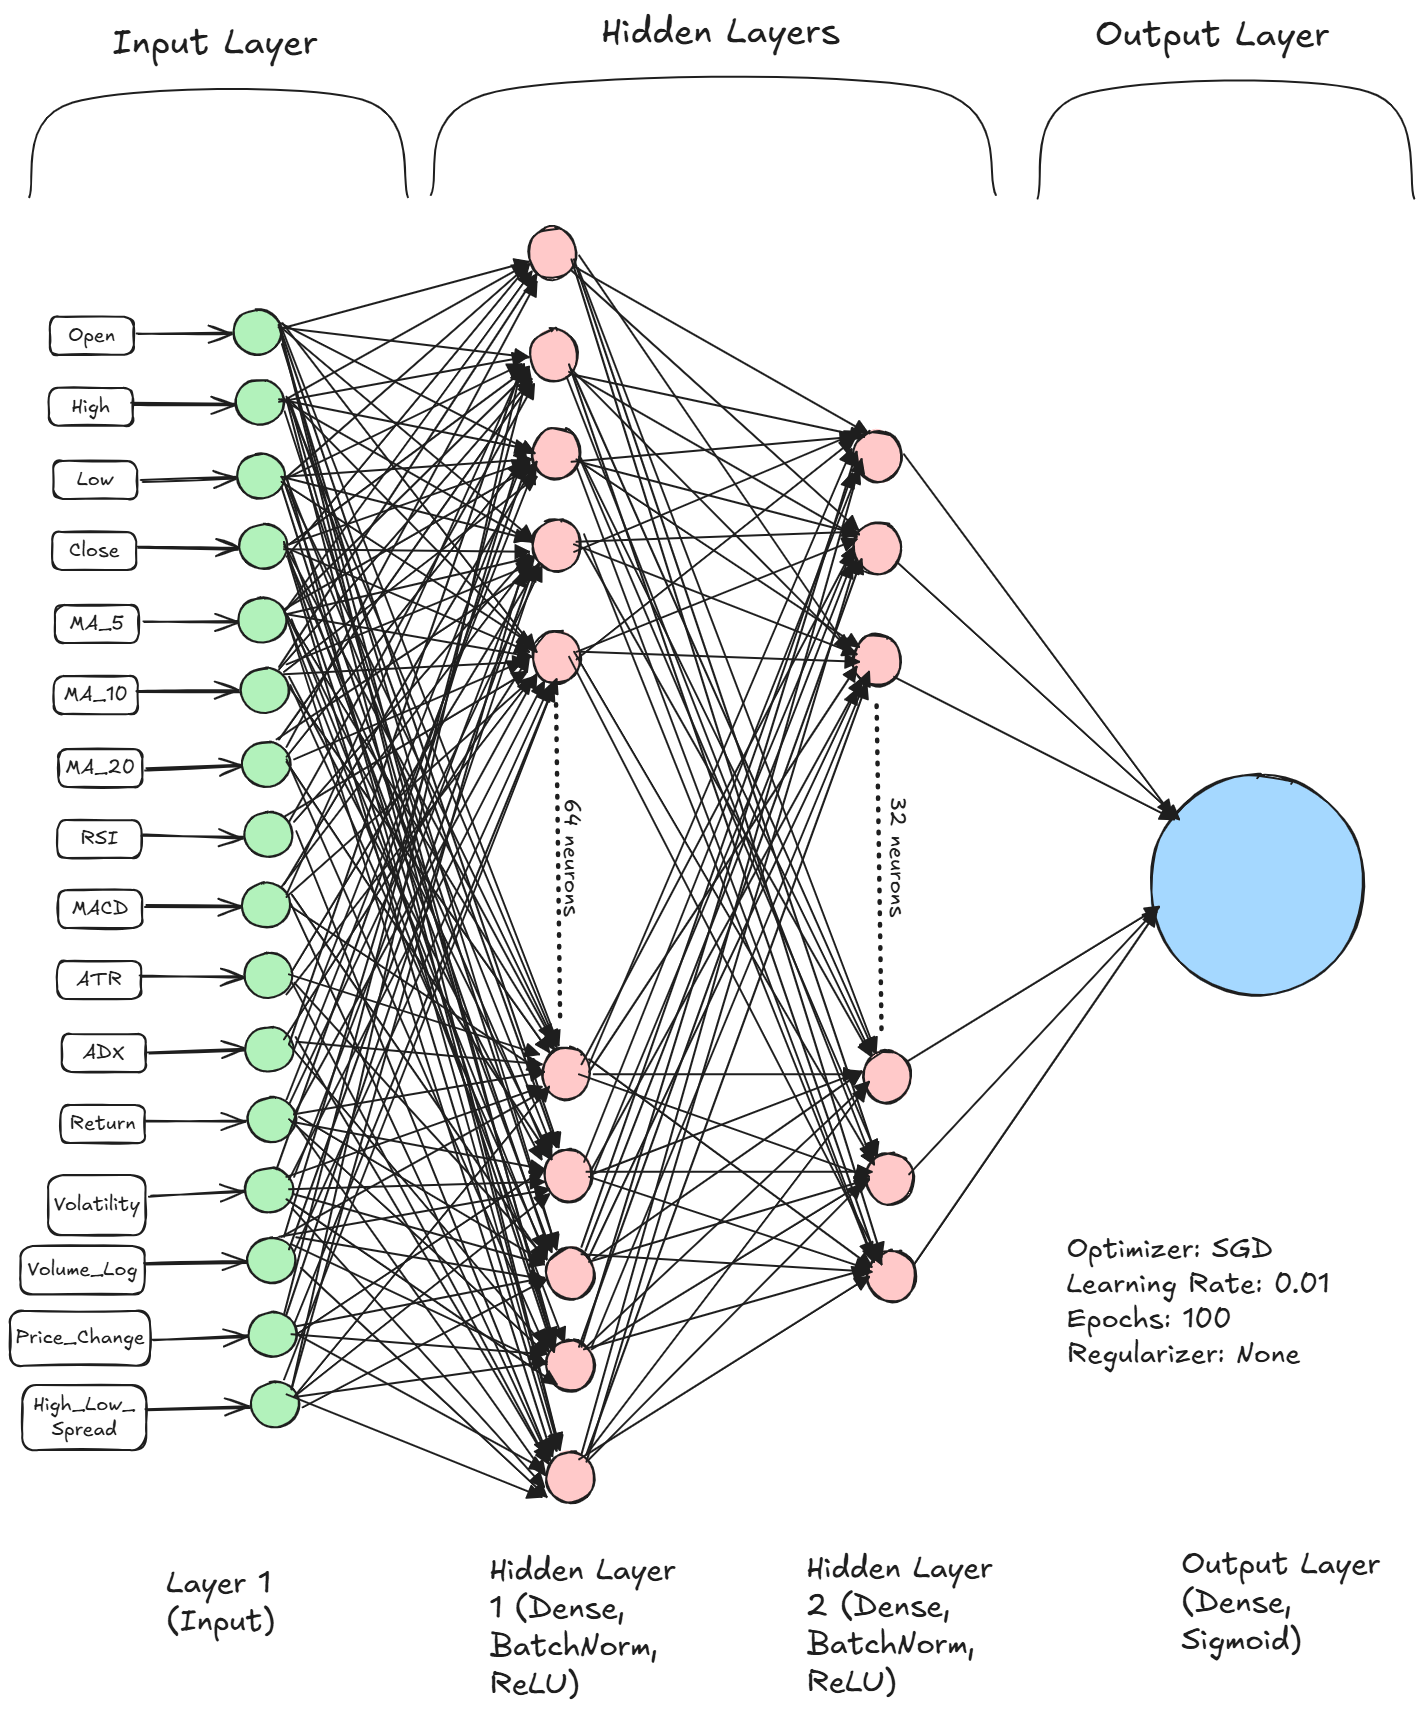

### **CLASSICAL ML MODELS**

This section systematically optimizes three key machine learning algorithms for EUR/USD direction prediction:

**1. Logistic Regression Optimization:**
- **Objective**: Find optimal regularization strength and type
- **Method**: Grid search over:
  - `C` (inverse regularization): 7 values from 0.001 to 1000 (logarithmic scale)
  - `penalty`: L1 (sparse solutions) and L2 (stable solutions)
- **Solver**: liblinear (handles both penalties efficiently)
- **Evaluation**: Uses F1-score to balance precision/recall

**2. SVM Optimization:**
- **Objective**: Tune kernel and margin parameters
- **Method**: Searches combinations of:
  - `C` (margin strictness): 0.1, 1, 10
  - `gamma` (kernel influence): 'scale', 'auto', 0.01, 0.1
  - `kernel`: Radial Basis Function (RBF) and Polynomial
- **Special Setting**: `probability=True` enables probability estimates
- **Purpose**: Capture non-linear price patterns

**3. XGBoost Optimization:**
- **Objective**: Optimize gradient boosting ensemble
- **Key Parameters**:
  - `n_estimators`: Tree count (100,200,300)
  - `max_depth`: Tree complexity (3,5,7)
  - `learning_rate`: Shrinkage factor (0.01,0.1,0.2)
  - Sampling: Row (`subsample`) and column (`colsample_bytree`) fractions
- **Prevention**: Disables deprecated label encoder

In [8]:
# Optimize Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr_params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2']
}
best_lr = optimize_ml_model(lr, lr_params, X_train_scaled, y_train)

# Optimize SVM
svm = SVC(random_state=42, probability=True)
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}
best_svm = optimize_ml_model(svm, svm_params, X_train_scaled, y_train)

# Optimize XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
best_xgb = optimize_ml_model(xgb, xgb_params, X_train_scaled, y_train)

# Evaluate ML models on validation set
ml_models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'XGBoost': best_xgb
}

ml_results = {}
for name, model in ml_models.items():
    results = evaluate_model(model, X_val_scaled, y_val)
    ml_results[name] = results
    print(f"\n{name} Validation Results:")
    print(f"Accuracy: {results['accuracy']:.4f}, F1: {results['f1']:.4f}")
    print(f"Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best params: {'C': np.float64(0.01), 'penalty': 'l2'}
Best f1: 0.5367
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Best f1: 0.6688
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best f1: 0.5314

Logistic Regression Validation Results:
Accuracy: 0.5058, F1: 0.5430
Precision: 0.5075, Recall: 0.5838
ROC AUC: 0.5054

SVM Validation Results:
Accuracy: 0.5019, F1: 0.6684
Precision: 0.5024, Recall: 0.9981
ROC AUC: 0.4990

XGBoost Validation Results:
Accuracy: 0.5136, F1: 0.5317
Precision: 0.5154, Recall: 0.5491
ROC AUC: 0.5134


### **NEURAL NETWORK MODELS**

This section implements a structured experimentation framework to optimize neural network architectures and training strategies for EUR/USD direction prediction. It systematically tests 5 distinct configurations combining different optimization techniques as required by the rubric.

**Key Components:**

1. **Configuration Matrix**:
   - 5 distinct neural network configurations with varying:
     - Optimizers (SGD, Adam, RMSprop, AdamW, Nadam)
     - Regularization techniques (None, L1, L2, L1+L2)
     - Dropout rates (0.0 to 0.5)
     - Learning rates (0.0001 to 0.01)
     - Network architectures (shallow to deep)
     - Training strategies (with/without early stopping)

2. **Technical Implementation**:
   - Uses the `create_nn_model()` function to dynamically build each architecture
   - Employs `train_nn_model()` for consistent training with optional early stopping
   - Utilizes `summarize_nn()` for comprehensive evaluation (metrics + visualizations)
   - Saves each trained model with descriptive filenames

3. **Experimental Design**:

| Instance | Optimization Focus              | Key Differentiators                          | Architecture       |
|----------|---------------------------------|----------------------------------------------|--------------------|
| 1        | Baseline                        | Vanilla SGD, no regularization               | [64, 32]           |
| 2        | Adam + Dropout                  | Adaptive optimizer + neuron dropping         | [128, 64]          |
| 3        | RMSprop + L1 Reg                | Momentum-based optimizer + sparsity          | [64, 64, 32]       |
| 4        | AdamW + Mixed Regularization    | Weight decay + elastic net regularization    | [256, 128]         |
| 5        | Nadam + Deep Architecture       | Nesterov momentum + deep layers              | [512, 256, 128]    |

4. **Hyperparameter Variations**:
   - **Learning Rates**: 0.0001 (Nadam) to 0.01 (SGD)
   - **Regularization**: L1 (sparsity), L2 (weight decay), L1+L2 (elastic net)
   - **Dropout**: Progressive increase (0.0 → 0.5) to test overfitting control
   - **Early Stopping**: Varying patience (5-10 epochs) or disabled


Training: Instance 1: Baseline
Config: {'name': 'Instance 1: Baseline', 'optimizer': 'sgd', 'learning_rate': 0.01, 'regularizer': None, 'reg_strength': 0.0, 'layers': [64, 32], 'dropout_rate': 0.0, 'activation': 'relu', 'epochs': 100, 'early_stopping': False, 'patience': None}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5002 - loss: 0.7396 - precision: 0.4999 - recall: 0.6445 - val_accuracy: 0.5126 - val_loss: 0.6976 - val_precision: 0.5159 - val_recall: 0.4990
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5153 - loss: 0.7032 - precision: 0.5132 - recall: 0.5624 - val_accuracy: 0.5165 - val_loss: 0.6975 - val_precision: 0.5192 - val_recall: 0.5222
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5250 - loss: 0.6951 - precision: 0.5225 - recall: 0.5526 - val_accuracy: 0.5223 - val_loss: 0.6977 - val_precision: 0.5237 - val_recall: 0.5530
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5281 - loss: 0.6906 - precision: 0.5257 - recall: 0.5517 - val_accuracy: 0.5242 - val_loss: 0.6977 - val_precision: 0.5258 - val_recall: 0.5491
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5356 - loss: 0.6876 - precision: 0.5332 - recall: 0.5583 - val_accuracy: 0.5184 - val_los

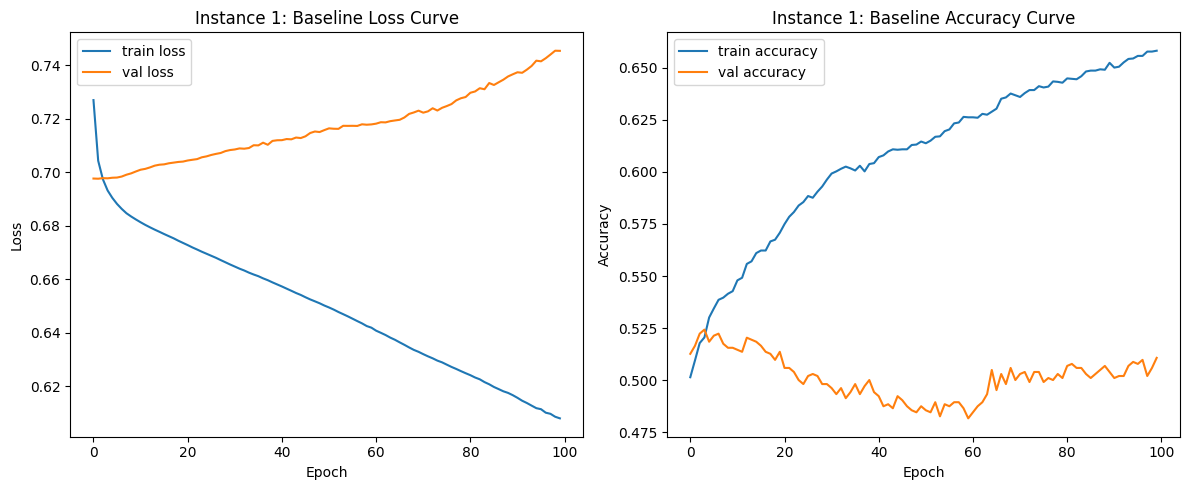

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


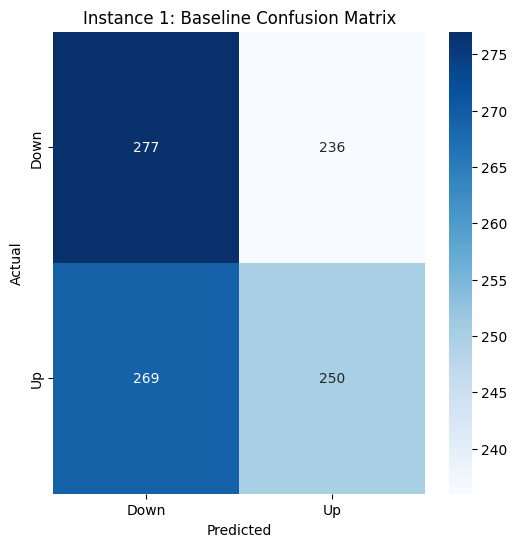

Saved model: saved_models/nn_instance_1.keras

Training: Instance 2: Adam + Dropout
Config: {'name': 'Instance 2: Adam + Dropout', 'optimizer': 'adam', 'learning_rate': 0.001, 'regularizer': None, 'reg_strength': 0.0, 'layers': [128, 64], 'dropout_rate': 0.3, 'activation': 'relu', 'epochs': 200, 'early_stopping': True, 'patience': 5}
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4953 - loss: 0.8929 - precision_1: 0.4973 - recall_1: 0.7741 - val_accuracy: 0.4942 - val_loss: 0.7024 - val_precision_1: 0.4915 - val_recall_1: 0.1676
Epoch 2/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5206 - loss: 0.7367 - precision_1: 0.5199 - recall_1: 0.5110 - val_accuracy: 0.4874 - val_loss: 0.7018 - val_precision_1: 0.4769 - val_recall_1: 0.1985
Epoch 3/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5298 - loss: 0.7141 - precision_1: 0.5295 - recall_1: 0.5147 - val_accuracy: 0.4884 - val_loss: 0.7019 - val_precision_1: 0.4879 - val_recall_1: 0.3507
Epoch 4/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5030 - loss: 0.7185 - precision_1: 0.5015 - recall_1: 0.4859 - val_accuracy: 0.4922 - val_loss: 0.7005 - val_precision_1: 0.4839 - val_recall_1: 0.1445
Epoch 5/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5219 - loss: 0.7074 - precision_1: 0.5213 - recall_1: 0.5160 - val_a

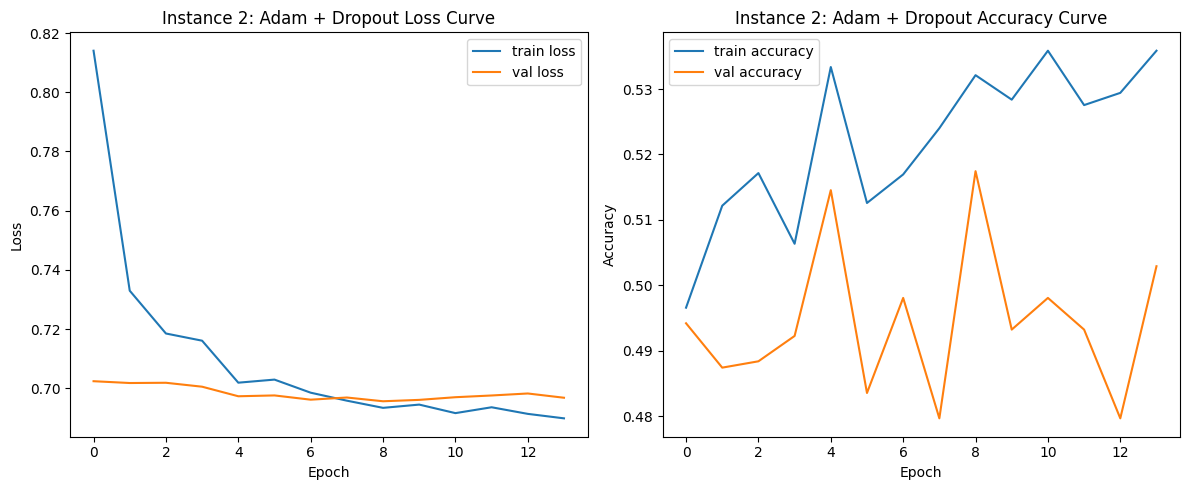

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


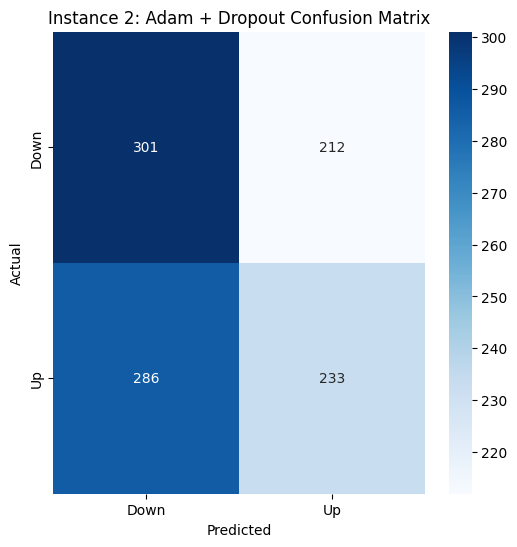

Saved model: saved_models/nn_instance_2.keras

Training: Instance 3: RMSprop + L1
Config: {'name': 'Instance 3: RMSprop + L1', 'optimizer': 'rmsprop', 'learning_rate': 0.0005, 'regularizer': 'l1', 'reg_strength': 0.001, 'layers': [64, 64, 32], 'dropout_rate': 0.2, 'activation': 'tanh', 'epochs': 150, 'early_stopping': True, 'patience': 5}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4918 - loss: 1.5725 - precision_2: 0.4905 - recall_2: 0.4890 - val_accuracy: 0.4961 - val_loss: 1.4737 - val_precision_2: 0.4990 - val_recall_2: 0.4913
Epoch 2/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4952 - loss: 1.4819 - precision_2: 0.4942 - recall_2: 0.5091 - val_accuracy: 0.4835 - val_loss: 1.4110 - val_precision_2: 0.4869 - val_recall_2: 0.5010
Epoch 3/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5023 - loss: 1.4160 - precision_2: 0.5008 - recall_2: 0.5059 - val_accuracy: 0.4777 - val_loss: 1.3477 - val_precision_2: 0.4803 - val_recall_2: 0.4701
Epoch 4/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5075 - loss: 1.3467 - precision_2: 0.5062 - recall_2: 0.4985 - val_accuracy: 0.4835 - val_loss: 1.2853 - val_precision_2: 0.4867 - val_recall_2: 0.4933
Epoch 5/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5101 - loss: 1.2735 - precision_2: 0.5092 - recall_2: 0

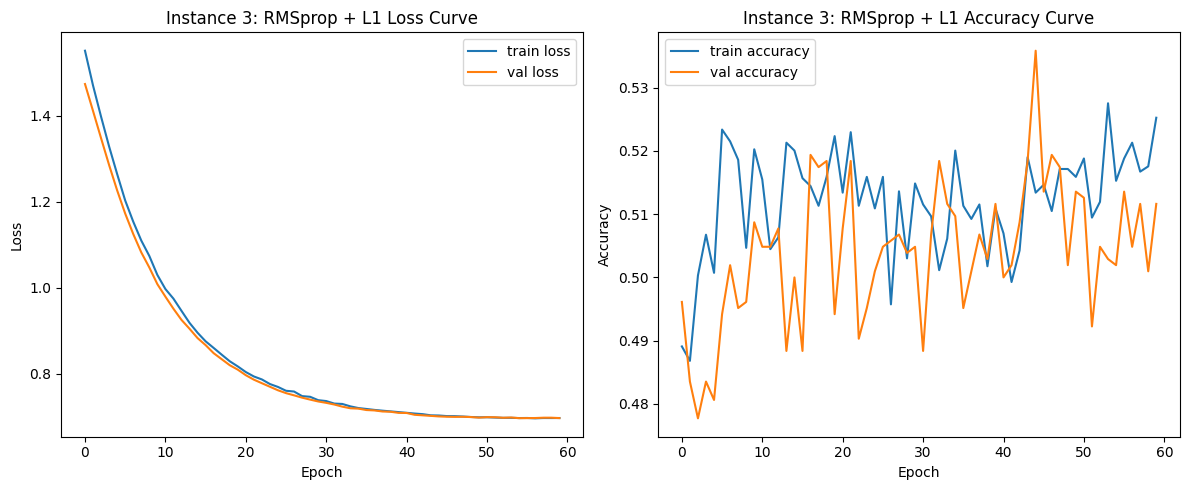

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


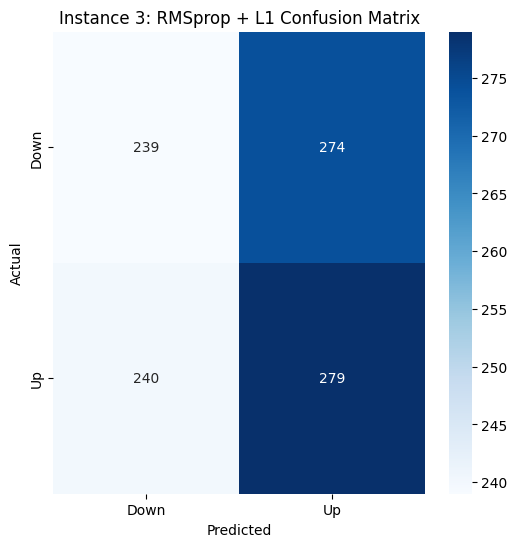

Saved model: saved_models/nn_instance_3.keras

Training: Instance 4: AdamW + L1_L2
Config: {'name': 'Instance 4: AdamW + L1_L2', 'optimizer': 'adamw', 'learning_rate': 0.005, 'regularizer': 'l1_l2', 'reg_strength': 0.01, 'layers': [256, 128], 'dropout_rate': 0.4, 'activation': 'swish', 'epochs': 100, 'early_stopping': False, 'patience': None}
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4965 - loss: 8.4126 - precision_3: 0.4948 - recall_3: 0.4890 - val_accuracy: 0.5039 - val_loss: 1.2129 - val_precision_3: 0.5034 - val_recall_3: 0.9981
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4946 - loss: 1.0455 - precision_3: 0.4932 - recall_3: 0.5002 - val_accuracy: 0.5029 - val_loss: 0.8626 - val_precision_3: 0.5029 - val_recall_3: 1.0000
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4895 - loss: 0.8618 - precision_3: 0.4850 - recall_3: 0.4152 - val_accuracy: 0.5029 - val_loss: 0.8694 - val_precision_3: 0.5029 - val_recall_3: 1.0000
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4792 - loss: 0.8751 - precision_3: 0.4604 - recall_3: 0.4025 - val_accuracy: 0.4971 - val_loss: 0.8910 - val_precision_3: 0.5000 - val_recall_3: 0.9730
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4861 - loss: 0.9085 - precision_3: 0.4843 - recall_3: 0.4057 - val_a

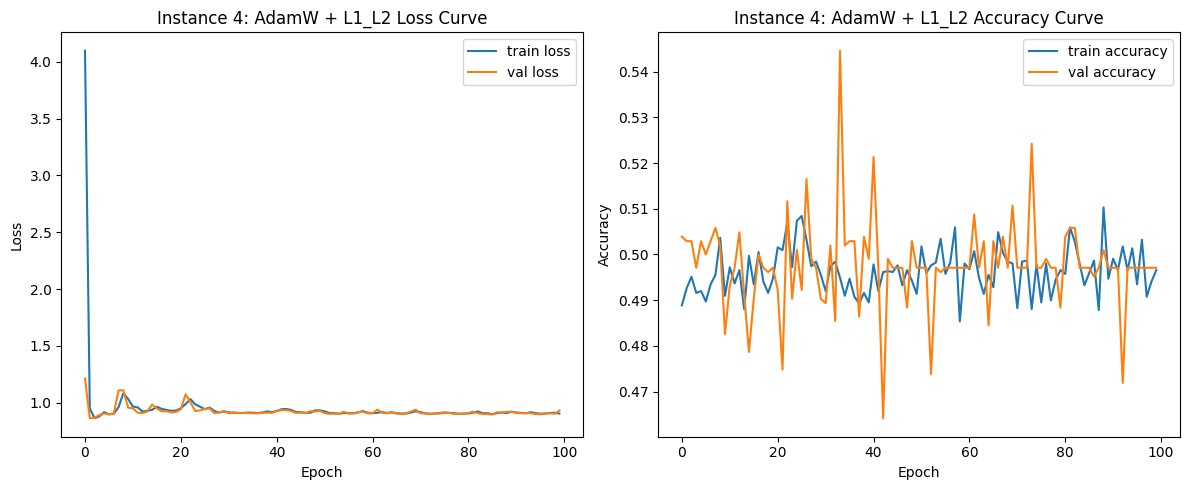

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


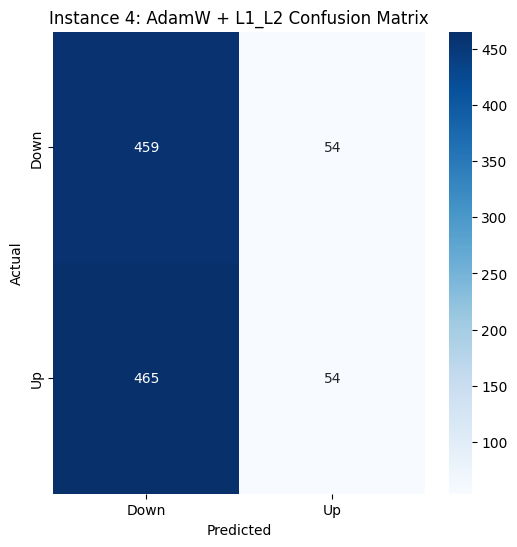

Saved model: saved_models/nn_instance_4.keras

Training: Instance 5: Nadam + Deep
Config: {'name': 'Instance 5: Nadam + Deep', 'optimizer': 'nadam', 'learning_rate': 0.0001, 'regularizer': 'l2', 'reg_strength': 0.001, 'layers': [512, 256, 128], 'dropout_rate': 0.5, 'activation': 'relu', 'epochs': 300, 'early_stopping': True, 'patience': 10}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4963 - loss: 1.4442 - precision_4: 0.4969 - recall_4: 0.7520 - val_accuracy: 0.5019 - val_loss: 1.2583 - val_precision_4: 0.5024 - val_recall_4: 0.9981
Epoch 2/300
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5016 - loss: 1.3864 - precision_4: 0.5004 - recall_4: 0.6558 - val_accuracy: 0.5010 - val_loss: 1.2452 - val_precision_4: 0.5020 - val_recall_4: 0.9827
Epoch 3/300
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4978 - loss: 1.3708 - precision_4: 0.4980 - recall_4: 0.5916 - val_accuracy: 0.4855 - val_loss: 1.2381 - val_precision_4: 0.4931 - val_recall_4: 0.8247
Epoch 4/300
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5209 - loss: 1.3168 - precision_4: 0.5182 - recall_4: 0.5557 - val_accuracy: 0.4971 - val_loss: 1.2267 - val_precision_4: 0.5000 - val_recall_4: 0.7206
Epoch 5/300
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4804 - loss: 1.3360 - precision_4: 0.4821 - recall_

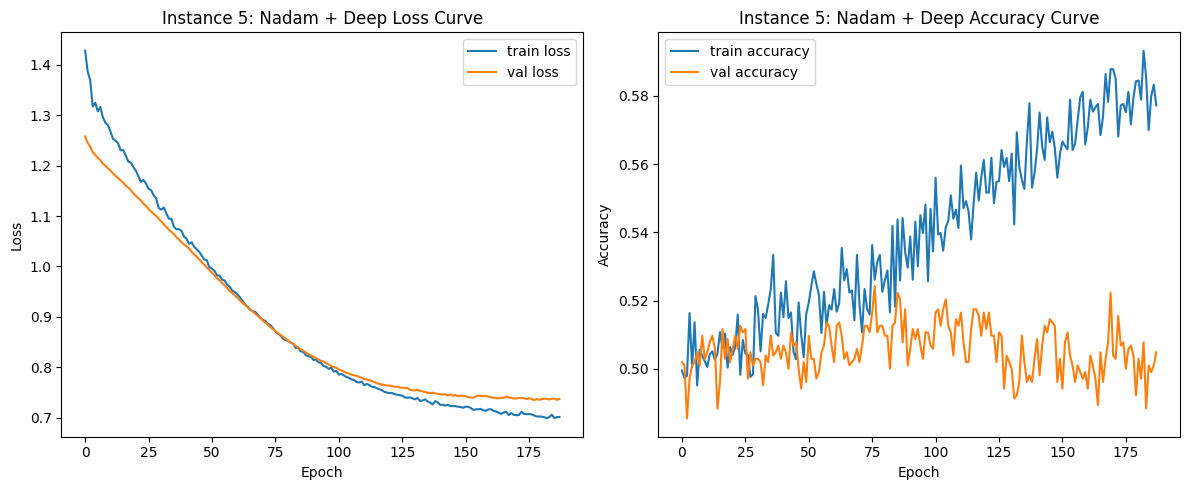

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


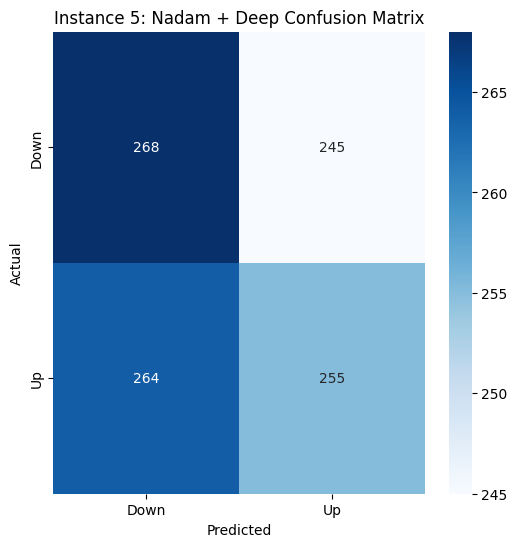

Saved model: saved_models/nn_instance_5.keras


In [9]:
# Define 5 distinct configurations
nn_configs = [
    # Instance 1: Baseline (no optimization)
    {
        'name': "Instance 1: Baseline",
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'regularizer': None,
        'reg_strength': 0.0,
        'layers': [64, 32],
        'dropout_rate': 0.0,
        'activation': 'relu',
        'epochs': 100,
        'early_stopping': False,
        'patience': None
    },
    # Instance 2: Adam + Dropout
    {
        'name': "Instance 2: Adam + Dropout",
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'regularizer': None,
        'reg_strength': 0.0,
        'layers': [128, 64],
        'dropout_rate': 0.3,
        'activation': 'relu',
        'epochs': 200,
        'early_stopping': True,
        'patience': 5
    },
    # Instance 3: RMSprop + L1 + Early Stopping
    {
        'name': "Instance 3: RMSprop + L1",
        'optimizer': 'rmsprop',
        'learning_rate': 0.0005,
        'regularizer': 'l1',
        'reg_strength': 0.001,
        'layers': [64, 64, 32],
        'dropout_rate': 0.2,
        'activation': 'tanh',
        'epochs': 150,
        'early_stopping': True,
        'patience': 5
    },
    # Instance 4: AdamW + L1_L2 + BatchNorm
    {
        'name': "Instance 4: AdamW + L1_L2",
        'optimizer': 'adamw',
        'learning_rate': 0.005,
        'regularizer': 'l1_l2',
        'reg_strength': 0.01,
        'layers': [256, 128],
        'dropout_rate': 0.4,
        'activation': 'swish',
        'epochs': 100,
        'early_stopping': False,
        'patience': None
    },
    # Instance 5: Nadam + Deep Architecture
    {
        'name': "Instance 5: Nadam + Deep",
        'optimizer': 'nadam',
        'learning_rate': 0.0001,
        'regularizer': 'l2',
        'reg_strength': 0.001,
        'layers': [512, 256, 128],
        'dropout_rate': 0.5,
        'activation': 'relu',
        'epochs': 300,
        'early_stopping': True,
        'patience': 10
    }
]

# Train and evaluate all NN configurations
nn_models = {}
nn_results = []

# Create the directory if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')


for config in nn_configs:
    print(f"\n{'='*50}")
    print(f"Training: {config['name']}")
    print(f"Config: {config}")
    print('='*50)

    # Create model
    model = create_nn_model(
        input_dim=X_train_scaled.shape[1],
        optimizer=config['optimizer'],
        learning_rate=config['learning_rate'],
        regularizer=config['regularizer'],
        reg_strength=config['reg_strength'],
        layers=config['layers'],
        dropout_rate=config['dropout_rate'],
        activation=config['activation']
    )

    # Train model
    history = train_nn_model(
        model,
        X_train_scaled, y_train,
        X_val_scaled, y_val,
        epochs=config['epochs'],
        early_stopping=config['early_stopping'],
        patience=config['patience']
    )

    # Evaluate and save results
    results = summarize_nn(config['name'], model, history, X_val_scaled, y_val)

    # Save model
    model_name = f"nn_{config['name'].split(':')[0].lower().replace(' ', '_')}"
    model.save(f"saved_models/{model_name}.keras")
    print(f"Saved model: saved_models/{model_name}.keras")

    # Store results
    config_results = config.copy()
    config_results.update(results)
    nn_results.append(config_results)

    # Store model reference
    nn_models[config['name']] = model

### **Final Evaluation and Prediction using the Best Saved Model**


FINAL TEST SET EVALUATION WITH CONFUSION MATRICES
Best ML model selected: SVM

Evaluating Best ML Model on Test Set...


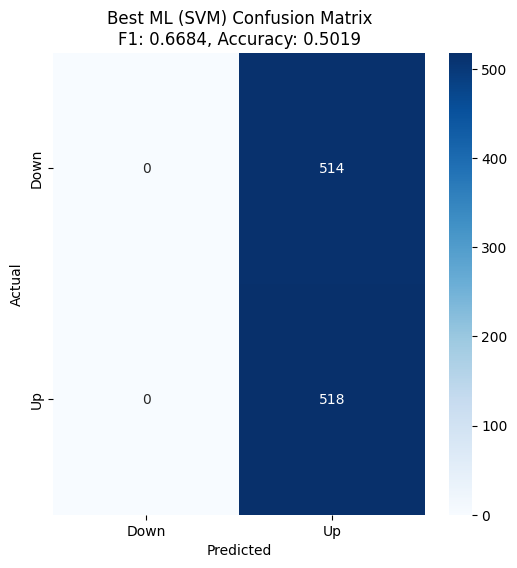


Best ML (SVM) Performance:
F1 Score: 0.6684, Accuracy: 0.5019
Precision: 0.5019, Recall: 1.0000
Best NN model selected: Instance 3: RMSprop + L1

Evaluating Best NN Model on Test Set...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


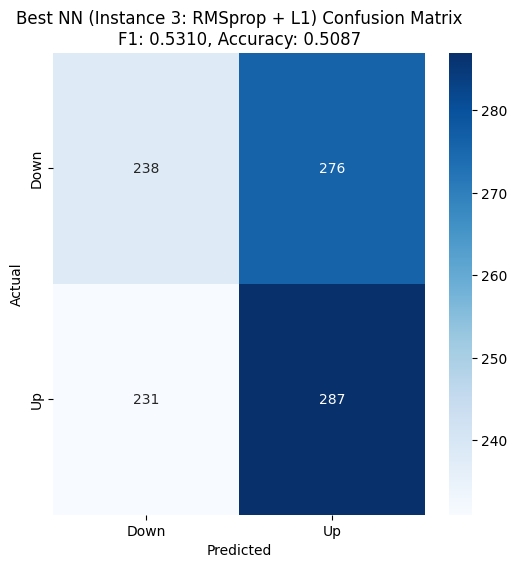


Best NN (Instance 3: RMSprop + L1) Performance:
F1 Score: 0.5310, Accuracy: 0.5087
Precision: 0.5098, Recall: 0.5541
Loss: 0.6970

MODEL COMPARISON SUMMARY
Metric       | Best ML    | Best NN    | Difference
------------|------------|------------|------------
F1 Score     | 0.6684    | 0.5310    | -0.1374
Accuracy     | 0.5019    | 0.5087    | +0.0068
Precision    | 0.5019    | 0.5098    | +0.0078
Recall       | 1.0000    | 0.5541    | +0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

First 10 Test Predictions:
   Actual  ML_Predicted  NN_Predicted
0       0             1             0
1       0             1             1
2       1             1             0
3       0             1             0
4       0             1             1
5       1             1             1
6       1             1             0
7       1             1             0
8       0             1             0
9       0             1             1


In [10]:
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION WITH CONFUSION MATRICES")
print("="*80)

def evaluate_with_confusion_matrix(model, X, y, name, model_type='sklearn'):
    """Evaluate model and display confusion matrix with metrics"""
    # Generate predictions
    if model_type == 'keras':
        y_pred = (model.predict(X) > 0.5).astype(int).flatten()
        loss = model.evaluate(X, y, verbose=0)[0]
    else:
        y_pred = model.predict(X)
        loss = 'N/A'

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'])
    plt.title(f"{name} Confusion Matrix\nF1: {f1:.4f}, Accuracy: {accuracy:.4f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print metrics
    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    if model_type == 'keras':
        print(f"Loss: {loss:.4f}")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'loss': loss
    }

# Select the best ML model based on validation F1 score
best_ml_name = max(ml_results, key=lambda k: ml_results[k]['f1'])
best_ml_model = ml_models[best_ml_name]
print(f"Best ML model selected: {best_ml_name}")


# 1. Evaluate best ML model
print("\nEvaluating Best ML Model on Test Set...")
ml_test_results = evaluate_with_confusion_matrix(
    best_ml_model,
    X_test_scaled,
    y_test,
    name=f"Best ML ({best_ml_name})"
)

# Select the best NN model based on validation F1 score
best_nn_result = max(nn_results, key=lambda k: k['f1'])
best_nn_name = best_nn_result['name']
best_nn_model = nn_models[best_nn_name]
print(f"Best NN model selected: {best_nn_name}")

# 2. Evaluate best NN model
print("\nEvaluating Best NN Model on Test Set...")
nn_test_results = evaluate_with_confusion_matrix(
    best_nn_model,
    X_test_scaled,
    y_test,
    name=f"Best NN ({best_nn_name})",
    model_type='keras'
)

# 3. Compare performance
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"{'Metric':<12} | {'Best ML':<10} | {'Best NN':<10} | {'Difference'}")
print(f"{'-'*12}|{'-'*12}|{'-'*12}|{'-'*12}")
print(f"{'F1 Score':<12} | {ml_test_results['f1']:.4f}    | {nn_test_results['f1']:.4f}    | {nn_test_results['f1'] - ml_test_results['f1']:+.4f}")
print(f"{'Accuracy':<12} | {ml_test_results['accuracy']:.4f}    | {nn_test_results['accuracy']:.4f}    | {nn_test_results['accuracy'] - ml_test_results['accuracy']:+.4f}")
print(f"{'Precision':<12} | {ml_test_results['precision']:.4f}    | {nn_test_results['precision']:.4f}    | {nn_test_results['precision'] - ml_test_results['precision']:+.4f}")
print(f"{'Recall':<12} | {ml_test_results['recall']:.4f}    | {nn_test_results['recall']:.4f}    | {nn_test_results['recall'] - nn_test_results['recall']:+.4f}")

# 4. Show sample predictions
sample_results = pd.DataFrame({
    'Actual': y_test[:10].values,
    'ML_Predicted': best_ml_model.predict(X_test_scaled[:10]),
    'NN_Predicted': (best_nn_model.predict(X_test_scaled[:10]) > 0.5).astype(int).flatten()
})
print("\nFirst 10 Test Predictions:")
print(sample_results)

## **Save All Models**

In [11]:
# Create directory if not exists
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save ML models
joblib.dump(best_lr, "saved_models/logistic_regression.pkl")
joblib.dump(best_svm, "saved_models/svm.pkl")
joblib.dump(best_xgb, "saved_models/xgboost.pkl")

# Save the best NN model
best_nn_model.save(f"saved_models/best_nn_model.keras")


print("\nAll models saved to saved_models/ directory")


All models saved to saved_models/ directory
